## **Faster rcnn pytorch**

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
from torchvision import transforms as T
from PIL import Image
import torchvision.datasets as dset

In [ ]:
# Hyperparameters
test_set_length = 40 		 # Test set (number of images)
train_batch_size = 8  		 # Train batch size
test_batch_size = 1    		 # Test batch size
num_classes = 3      		 # Number of classes
learning_rate = 0.005  		 # Learning rate
num_epochs = 70     	     # Number of epochs
output_dir = "######################"   # Output directory to save the model


In [ ]:
from torch.utils.data import DataLoader

In [ ]:

def get_model(num_classes):

	# Load an pre-trained object detectin model (in this case faster-rcnn)
	model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

	# Number of input features
	in_features = model.roi_heads.box_predictor.cls_score.in_features

	# Replace the pre-trained head with a new head
	model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

	return model


In [ ]:

def get_transforms(train):

	transforms = []

	# Convert numpy image to PyTorch Tensor
	transforms.append(T.ToTensor())


	return T.Compose(transforms)

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from torchvision.datasets import CocoDetection #dedicated module to load coco data set

In [ ]:


if __name__ == '__main__':

	# Setting up the device
	device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


	# # Define train and test dataset
	train_d = CocoDetection(root = "################", annFile = "######################",
							 transform = get_transforms(train = True))

	test_d = CocoDetection(root = "###################", annFile = "################################",
							 transform = get_transforms(train = False))

	# Define train and test dataloaders
	data_loader = torch.utils.data.DataLoader(dataset=train_d, batch_size = train_batch_size, shuffle = True,
					 collate_fn=collate_fn(train_d))

	data_loader_test = torch.utils.data.DataLoader(dataset=test_d, batch_size = test_batch_size, shuffle = False,
					 collate_fn=collate_fn(test_d))


	# Get the model using helper function
	model = get_model(num_classes)
	model.to(device = device)

	# Construct the optimizer
	params = [p for p in model.parameters() if p.requires_grad]
	optimizer = torch.optim.SGD(params, lr = learning_rate, momentum = 0.9, weight_decay = 0.0005)

	# Learning rate scheduler decreases the learning rate by 10x every 3 epochs
	lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

	for epoch in range(num_epochs):
		
		train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq = 10)
		lr_scheduler.step()
		# Evaluate on the test dataset
		evaluate(model, data_loader_test, device = device)

	if not os.path.exists(output_dir):
		os.mkdir(output_dir)

	# Save the model state	
	torch.save(model.state_dict(), output_dir + "/model_object_detection")

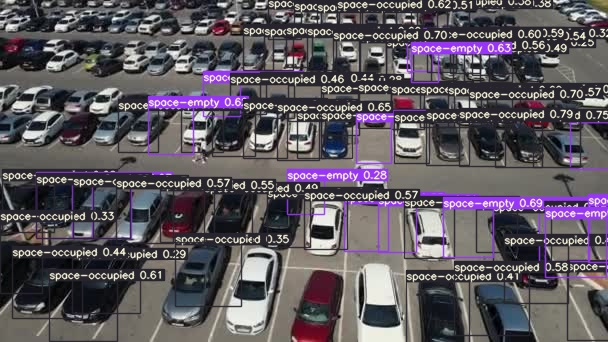

In [1]:
from IPython.display import Image
Image(filename='/Users/tanishsingh/Downloads/yolov7/runs/detect/exp3/stock-video-4k-footage-of-the-drone.jpeg') 